# E190AV Final Project: Movie Rating Predictor

**Claire Chang and Thaxter Shaw**

In this notebook, we will use movie ratings and tags (such as “epic”, “medieval”, “Steven Spielberg”, and “lawn mower”) to predict how a reviewer will rate an arbitrary movie based on their pre-existing ratings.

We will use data from https://grouplens.org/datasets/movielens/. To begin, we will use the `genome-scores.csv` and `ratings.csv` files from `ml-latest.zip`, which contains “27,000,000 ratings and 1,100,000 tag applications applied to 58,000 movies by 280,000 users," along with "14 million relevance scores across 1,100 tags." Later, we can consider using `movies.csv` to recommend movies.

*   `genome-scores.csv`: columns of movieId, tagId, and relevance
*   `ratings.csv`: columns of userId, movieId, rating, and timestamp
*    `movies.csv`: columns of movieId, title, and genres

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy.matlib
import librosa as lb
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import normalize
# from sklearn.metrics import confusion_matrix
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install lenskit
from lenskit import crossfold
from lenskit.metrics.predict import rmse, mae

     |████████████████████████████████| 92kB 3.1MB/s 
     |████████████████████████████████| 133kB 15.7MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219253 sha256=8111fa7ce616b0ab1106bbcc54abe02d648a228dcc4bbac4e8110c6d54bb9173
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [4]:
# Note: change the directory if necessary, according to your Google Drive file structure
rootdir = '/content/drive/My Drive/2020-2021/Spring 2021/ENGR190AV: Signal Processing/Final Project/'

## Process Data

First, we convert the information currently stored in a spreadsheet into a matrix.

In [5]:
# convert .csv file to pandas dataframe
ratingsFile = rootdir + 'data/' + 'ratingsfiltered.csv'
df = pd.read_csv(ratingsFile, dtype={
    'movieId': np.int32,
    'userId': np.int32,
    'rating': np.float64,
    'timestamp': np.int32
}, header = 0, usecols = [0, 1, 2])

In [6]:
df.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,2,170,3.5
3,2,849,3.5
4,3,640,3.0


We have created a modified .csv file that only contains rows with movie IDs that are <= 1024, because `genome-scores.csv` only contains data up to movieId 1024. So, we must further filter that data so that we only use users who have rated at least 20 movies.

In [7]:
counts = df['userId'].value_counts()
df = df[df['userId'].map(df['userId'].value_counts()) >= 20]
df.head()

,userId,movieId,rating
7,4,1,4.0
8,4,2,4.0
9,4,5,2.0
10,4,6,4.5
11,4,10,4.0


Next, we split the dataset so we have a testing set to evaluate our algorithm on later. From the dataset, we are guaranteed that each user will complete at least 20 ratings, so we will not filter users that have completed less than $x$ amount of ratings, assuming that even after the training/testing split, each user will have completed a sufficient number of ratings that NMF will still be effective.

In [8]:
# split the data with 80% for training and 20% for testing
trainingData, testData = crossfold.sample_rows(df, partitions=None, size=int(.2*len(df['userId'])))
print("Number of samples in training dataset: ", len(trainingData))
print("Number of samples in testing dataset: ", len(testData))

Number of samples in training dataset:  163940
Number of samples in testing dataset:  40984


In [9]:
def generateRatingsMatrix(trainingData):
    '''
    Convert ratings csv file to a matrix.
    
    Arguments:
    trainingData -- a dataframe specifying user ID, movie ID, and rating in columns 1, 2, and 3 respectively for training data
    
    Returns:
    ratings -- a matrix where entry (i-1,j-1) describes the rating of user j for movie i (rows are movies and columns are users), of dimension m x p
    '''
    # create an empty matrix of dimensions m by p, where m is the max movie index and p is the max user ID
    ratings = np.zeros((trainingData['movieId'].max(),trainingData['userId'].max()))

    # for each movie rating, enter it into the matrix
    for _, entry in trainingData.iterrows():
      ratings[int(entry['movieId'])-1,int(entry['userId'])-1] = entry['rating']

    return ratings

In [10]:
ratings = generateRatingsMatrix(trainingData)

In [11]:
ratings.shape

(1024, 10532)

Now, we want to create a matrix that describes the affinity of each person in the training data set to a particular tag ("lawn mower", "Steven Spielberg", "comedy", etc).

In `genome-scores.csv`, we have `movieId`, `tagId`, and `relevance`. We will make a matrix that has dimension $t \times p$, where $t$ is the number of tags and $p$ is the number of people in the training data set. For each row in our ratings matrix, we will add the relevance for a particular tag in that movie to the user's affinity for that tag.

In [12]:
def generateTagAffinityMatrix(ratingsMatrix, tagsFile):
  '''
  Generate a matrix describing the affinity of each rater to each tag, and a matrix describing the affinity of each movie to each tag

  Arguments:
  ratingsMatrix -- an m x p matrix where entry (i-1,j-1) describes the rating of user j for movie i
  tagsFile -- a .csv file with columns of movieId, tagId, and relevance

  Returns:
  tags -- a matrix of dimension t x p, where t is the number of different tags, and the (i-1,j-1) entry describes the affinity of rater j towards tag i
  movieTags -- a matrix of dimension t x m, where m is the number of movies
  '''
  # process the tags file
  df = pd.read_csv(tagsFile, dtype={
      'movieId': np.int32,
      'tagId': np.int32,
      'relevance': np.float64
  }, header = 0)

  # create a matrix equivalent of the tags file that contains relevance information for each tag for each movie
  numTags = df['tagId'].max()
  movieTags = np.zeros((numTags, 1024))  # replace 1024 with df['movieId'].max()?
  for i in range(movieTags.shape[1]):
    try:
      movieTags[:, i] = df.iloc[i*numTags:(i+1)*numTags]['relevance']
    except:
      print("Stopped at i ", i)
      break

  # create an empty matrix of size t by p
  tags = np.zeros((numTags, ratingsMatrix.shape[1]))

  # for each movie rating, enter it into the matrix
  for i in range(ratingsMatrix.shape[0]):
    tags += ratingsMatrix[i,:].reshape(1,-1) * movieTags[:,i].reshape(-1,1)

  return tags, movieTags

In [13]:
tags, movieTags = generateTagAffinityMatrix(ratings, rootdir + 'data/' + 'genome-scores.csv')

In [14]:
tags[0:10,0:10]

array([[ 0.      ,  0.      ,  0.      , 22.993125,  0.      ,  9.35725 ,
         0.      ,  1.79175 ,  0.      ,  9.726   ],
       [ 0.      ,  0.      ,  0.      , 21.970625,  0.      ,  8.12475 ,
         0.      ,  2.0085  ,  0.      ,  6.97475 ],
       [ 0.      ,  0.      ,  0.      , 31.7885  ,  0.      ,  9.60375 ,
         0.      ,  3.57975 ,  0.      , 12.8245  ],
       [ 0.      ,  0.      ,  0.      , 26.880875,  0.      ,  8.24075 ,
         0.      ,  6.97    ,  0.      ,  9.92625 ],
       [ 0.      ,  0.      ,  0.      , 54.25575 ,  0.      , 15.49875 ,
         0.      ,  6.2375  ,  0.      , 21.75825 ],
       [ 0.      ,  0.      ,  0.      , 36.07225 ,  0.      , 14.8355  ,
         0.      ,  5.73525 ,  0.      , 16.22625 ],
       [ 0.      ,  0.      ,  0.      , 24.35325 ,  0.      ,  6.329   ,
         0.      ,  3.912   ,  0.      , 11.97725 ],
       [ 0.      ,  0.      ,  0.      , 49.601375,  0.      , 18.603   ,
         0.      ,  8.57725 ,  0.    

In [15]:
movieTags[0:10,0:10]

array([[0.029  , 0.03625, 0.0415 , 0.0335 , 0.0405 , 0.02925, 0.04775,
        0.03125, 0.03225, 0.9995 ],
       [0.02375, 0.03625, 0.0495 , 0.03675, 0.05175, 0.02575, 0.05075,
        0.0375 , 0.0355 , 1.     ],
       [0.05425, 0.08275, 0.03   , 0.04275, 0.036  , 0.027  , 0.134  ,
        0.0805 , 0.0215 , 0.0305 ],
       [0.06875, 0.08175, 0.09525, 0.02625, 0.04625, 0.0345 , 0.08825,
        0.0315 , 0.0165 , 0.0515 ],
       [0.16   , 0.102  , 0.04525, 0.0525 , 0.055  , 0.06825, 0.0955 ,
        0.051  , 0.0235 , 0.0785 ],
       [0.19525, 0.069  , 0.05925, 0.03025, 0.08   , 0.04675, 0.195  ,
        0.0175 , 0.01975, 0.0855 ],
       [0.076  , 0.05775, 0.04   , 0.02425, 0.0215 , 0.04675, 0.054  ,
        0.01475, 0.0145 , 0.12125],
       [0.252  , 0.101  , 0.1415 , 0.07475, 0.07375, 0.23375, 0.08975,
        0.0765 , 0.046  , 0.122  ],
       [0.2275 , 0.08225, 0.04075, 0.0375 , 0.02825, 0.1085 , 0.037  ,
        0.025  , 0.01175, 0.0735 ],
       [0.024  , 0.0525 , 0.032  , 0.

In [16]:
movieTags.shape

(1128, 1024)

We see 0's wherever a user (column) has not rated a movie.

## Investigate Data

We take a brief aside to visualize some of the ratings.

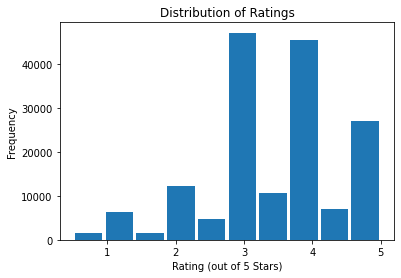

In [17]:
plt.hist(ratings.flatten()[ratings.flatten() != 0], bins=10, rwidth=0.9);
plt.title("Distribution of Ratings");
plt.xlabel("Rating (out of 5 Stars)");
plt.ylabel("Frequency");

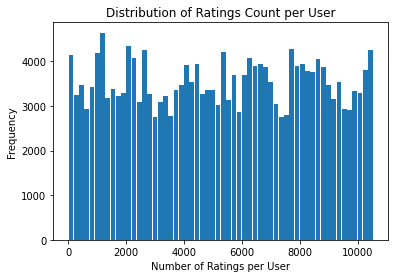

In [18]:
plt.hist(df['userId'], bins='auto', rwidth=0.9);
plt.title("Distribution of Ratings Count per User");
plt.xlabel("Number of Ratings per User");
plt.ylabel("Frequency");

## NMF

Now apply NMF to create templates in W and each reviewer’s breakdown by template in H. Each template represents a collection of tags that a reviewer might like. 

*Note that we normalize H along the columns so that their total affinity adds up to 1 regardless of the number of ratings they have submitted.*

*So that it runs faster, we will use librosa's decompose function to calculate the NMF.*

In [19]:
W, H = lb.decompose.decompose(movieTags,n_components=50)

Here, we see that each of the types/genres (columns) has a lot of tags associated with it (rows).

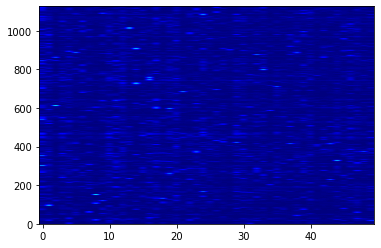

In [20]:
plt.imshow(W, aspect = 'auto', origin = "lower", cmap = 'jet');

We can also see that for each movie (columns), there are associated types (rows).

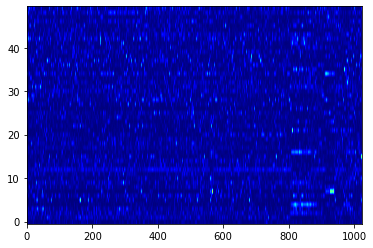

In [21]:
plt.imshow(H, aspect = 'auto', origin = "lower", cmap = 'jet');

In comparison with HW10 and the xylophone, we notice that there the graphs are more scattered, which is likely because the movies and tags are not grouped by similarity and there's also a lot of them, whereas the notes were held for some amount of time. If we look at a smaller selection of movies and tags, the graph becomes more clear.

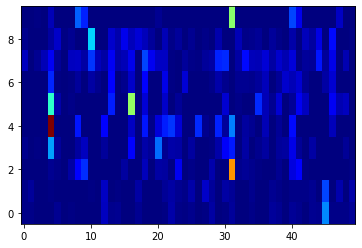

In [22]:
plt.imshow(W[0:10], aspect = 'auto', origin = "lower", cmap = 'jet');

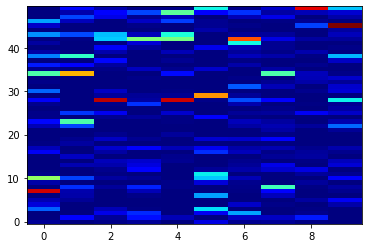

In [23]:
plt.imshow(H[:,0:10], aspect = 'auto', origin = "lower", cmap = 'jet');

## Prediction

Next, we use H and `ratings.csv` to find $M$, a template affinity matrix where each column is a person and each row is a movie template, so the value at the $i$th row and $j$th column tells us what to expect person $j$ to rate a movie of template $i$.

We will calculate the expected rating located at `templateRatings[i][j]` by finding $$\frac{\sum_{movies} H[movie_m,i] \times ratingsMatrix[movie_m, j]}{\sum_{movies} H[movie_m,i]} $$

In [24]:
def generateTemplateRatingsMatrix(ratingsMatrix, H):
  '''
  Generate a matrix describing the affinity of each rater to each tag, and a matrix describing the affinity of each movie to each tag

  Arguments:
  ratingsMatrix -- an m x p matrix where entry (i-1,j-1) describes the rating of user j for movie i
  H -- the activation matrix of size R x m that results from the NMF algorithm

  Returns:
  templateRatings -- a matrix of dimension R x p, where R is the number of templates, 
                      and the (i-1,j-1) entry describes the expected rating of rater j towards matrix template i
  '''

  # create an empty matrix of size R by p
  templateRatings = np.zeros((H.shape[0], ratingsMatrix.shape[1]))
  counts = np.zeros((H.shape[0], ratingsMatrix.shape[1]))
  mask = (ratingsMatrix != 0) * 1

  # for each movie rating, add weighted rating to each template and keep track of total weights
  for i in range(ratingsMatrix.shape[0]):
    templateRatings += ratingsMatrix[i,:].reshape(1,-1) * H[:,i].reshape(-1,1)
    counts += mask[i,:].reshape(1,-1) * H[:,i].reshape(-1,1)


  return templateRatings / (counts + 10**-9)

In [25]:
templateRatings = generateTemplateRatingsMatrix(ratings, H)

In [26]:
templateRatings[0:10,0:10]

array([[0.        , 0.        , 0.        , 3.20478178, 0.        ,
        4.17234598, 0.        , 3.0430804 , 0.        , 4.5251957 ],
       [0.        , 0.        , 0.        , 3.10591309, 0.        ,
        3.54257047, 0.        , 3.50032669, 0.        , 4.45717411],
       [0.        , 0.        , 0.        , 3.21916342, 0.        ,
        3.50939748, 0.        , 3.71738329, 0.        , 4.39048055],
       [0.        , 0.        , 0.        , 3.88434262, 0.        ,
        4.55397183, 0.        , 3.22642994, 0.        , 4.16543023],
       [0.        , 0.        , 0.        , 3.34509961, 0.        ,
        3.59487218, 0.        , 3.28265612, 0.        , 4.54671726],
       [0.        , 0.        , 0.        , 2.84817688, 0.        ,
        4.22180828, 0.        , 3.74122906, 0.        , 3.57321865],
       [0.        , 0.        , 0.        , 3.30055783, 0.        ,
        4.36737642, 0.        , 2.75356949, 0.        , 4.0529216 ],
       [0.        , 0.        , 0.       

In [27]:
print("Highest Rating: ", templateRatings.max())  # confirm that we stay <= 5, the max rating
print("Lowest Rating: ", templateRatings.min())  # confirm that we stay >= 0, the lowest rating

Highest Rating:  4.999999999020912
Lowest Rating:  0.0


To predict the rating given a movie and a person, we should use the normalized $H$ matrix and $M$ matrix, then calculate a linear combination with the breakdown of the movie template from $H$ and the ratings for each template from $M$.

In [28]:
def predictRating(movieId, userId, normalizedH, M, maxGenre=False):
  '''
  Predict the rating that the given person would rate the given movie, provided with the template activation matrix and template ratings matrix

  Arguments:
  movieId -- the given movieId
  userId -- the given userId
  normalizedH -- a normalized (by column) version of the H matrix from the NMF algorithm of size R x m
  M -- the template ratings matrix of size R x p
  maxGenre -- only look at the most important genre?

  Returns:
  rating -- a float for the expected rating of movie by person
  '''
  # later, replace this with an ID to index function
  userIndex = userId - 1
  movieIndex = movieId - 1

  # multiply H and M elementwise to weight each rating, then sum those weighted ratings
  if maxGenre:
    rating = M[np.argmax(normalizedH[:,movieIndex]), userIndex]
  else:
    rating = np.sum(normalizedH[:,movieIndex] * M[:,userIndex])
  return rating

In [29]:
normalizedH = normalize(H, norm='l1', axis=0)

In [30]:
userIndex = 4 - 1
allRatings = np.sum(normalizedH * templateRatings[:,userIndex].reshape(-1,1), axis = 0)
print(allRatings.max())
print(allRatings.min())

3.4038826595116474
2.819292859849701


In [31]:
predictRating(1, 4, normalizedH, templateRatings)

3.3418132093801596

In [32]:
predictRating(2, 4, normalizedH, templateRatings)

3.2605671065363224

In [33]:
predictRating(5, 4, normalizedH, templateRatings)

3.2390844537122656

In [34]:
predictRating(6, 4, normalizedH, templateRatings)

3.191877190953148

In [35]:
predictRating(10, 4, normalizedH, templateRatings)

3.2236232023771554

## Evaluation

In [36]:
testData.head()

,userId,movieId,rating
158463,6787,594,5.0
228101,9790,158,3.0
116823,5046,233,4.0
61865,2585,223,4.0
41712,1769,924,4.0


In [37]:
def calcRatings(data, normalizedH, M, maxGenre = False):
  '''
  Given a set of data, add a column to it for the expected rating

  Arguments:
  data -- the dataframe with testing data
  normalizedH -- a normalized (by column) version of the H matrix from the NMF algorithm of size R x m
  M -- the template ratings matrix of size R x p
  maxGenre -- whether to only look at the most important genre

  Returns:
  data -- the modified dataset, with an additional column called expectedRating
  '''
  # for each rating (row in data), call the predictRating() function and append that expected rating to a list
  expectedRatings = []

  for _,x in data.iterrows():
    expectedRatings.append(predictRating(int(x['movieId']), int(x['userId']), normalizedH, M, maxGenre = maxGenre))

  # add a column to the dataframe with the expected ratings, then return that modified dataframe
  data['expectedRatings'] = expectedRatings
  return data

In [38]:
testData2 = calcRatings(testData, normalizedH, templateRatings)

In [39]:
testData2.head()

,userId,movieId,rating,expectedRatings
158463,6787,594,5.0,4.342730
228101,9790,158,3.0,3.413915
116823,5046,233,4.0,3.789079
61865,2585,223,4.0,4.007886
41712,1769,924,4.0,3.453498


In [40]:
print("Minimum expected rating: ", testData2['expectedRatings'].min())
print("Maximum expected rating: ", testData2['expectedRatings'].max())

Minimum expected rating:  0.7737366475394393
Maximum expected rating:  4.999999998189311


In [41]:
testData3 = testData2.sort_values(by='expectedRatings')

In [42]:
testData3.head()

,userId,movieId,rating,expectedRatings
184893,7932,413,2.0,0.773737
184931,7932,543,0.5,0.773760
184788,7932,5,0.5,0.785775
185033,7932,1021,0.5,0.808632
185009,7932,922,0.5,0.817523


In [43]:
testData3.tail()

,userId,movieId,rating,expectedRatings
78173,3332,743,5.0,5.0
78139,3332,94,5.0,5.0
78154,3332,362,5.0,5.0
78188,3332,849,5.0,5.0
78132,3332,63,5.0,5.0


In [44]:
rmse(testData2['expectedRatings'], testData2['rating'])

0.9643419224734368

## Compare to the naive median approach...

Knowing that we can use the $i$th column of H and and $j$th column of M to find expected rating of person $i$ for movie $j$, we can now test our predictions.

We will predict the ratings for the data we set aside as a testing set, and compare to the true rating values.

In [45]:
def averageMovieRating(data, ratingsMatrix):
  '''
  Calculate the average movie rating for all movies

  Arguments:
  data -- the dataframe with the testing data
  ratingsMatrix -- a matrix where entry (i-1,j-1) describes the rating of user j for movie i (rows are movies and columns are users), of dimension m x p

  Returns:
  data -- the modified dataframe with columns added for the mean and median ratings for each movie
  '''
  # add columns to data for mean and median movie rating
  # change from -1 to idToIndex function?
  meanMovieRating = []
  medianMovieRating = []

  # calculate the mean and median ratings for each movie
  for _, entry in data.iterrows():
    # change from -1 to idToIndex function?
    movieIndex = int(entry["movieId"] - 1)
    movieRow = ratingsMatrix[movieIndex,:]
    movieMean = np.mean(movieRow[movieRow != 0])
    movieMed = np.median(movieRow[movieRow != 0])
    meanMovieRating.append(movieMean)
    medianMovieRating.append(movieMed)

  data['meanMovieRating'] = meanMovieRating
  data['medianMovieRating'] = medianMovieRating

  return data
  

In [46]:
def averageUserRating(data, ratingsMatrix):
  '''
  Calculate the average movie rating for all movies

  Arguments:
  data -- the dataframe with the testing data
  ratingsMatrix -- a matrix where entry (i-1,j-1) describes the rating of user j for movie i (rows are movies and columns are users), of dimension m x p

  Returns:
  data -- the modified dataframe with columns added for the mean and median ratings for each movie
  '''
  # add columns to data for mean and median movie rating
  # change from -1 to idToIndex function?
  meanUserRating = []
  medianUserRating = []

  # calculate the mean and median ratings for each user
  for _, entry in data.iterrows():
    # change from -1 to idToIndex function?
    userIndex = int(entry["userId"] - 1)
    userRow = ratingsMatrix[:,userIndex]
    userMean = np.mean(userRow[userRow != 0])
    userMed = np.median(userRow[userRow != 0])
    meanUserRating.append(userMean)
    medianUserRating.append(userMed)

  data['meanUserRating'] = meanUserRating
  data['medianUserRating'] = medianUserRating

  return data
  

In [47]:
testData3 = averageMovieRating(testData, ratings)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [48]:
testData3.head()

,userId,movieId,rating,expectedRatings,meanMovieRating,medianMovieRating
158463,6787,594,5.0,4.342730,3.573636,3.5
228101,9790,158,3.0,3.413915,2.997159,3.0
116823,5046,233,4.0,3.789079,3.505155,4.0
61865,2585,223,4.0,4.007886,3.809838,4.0
41712,1769,924,4.0,3.453498,3.916005,4.0


In [49]:
print("Root Mean Squared Error for Mean: ", rmse(testData3['meanMovieRating'], testData3['rating']))
print("Root Mean Squared Error for Median: ", rmse(testData3['medianMovieRating'], testData3['rating']))

Root Mean Squared Error for Mean:  0.9526509331826387
Root Mean Squared Error for Median:  0.9785488193377829


In [50]:
testData4 = averageUserRating(testData, ratings)

In [51]:
testData4.head()

,userId,movieId,rating,expectedRatings,meanMovieRating,medianMovieRating,meanUserRating,medianUserRating
158463,6787,594,5.0,4.342730,3.573636,3.5,4.540541,5.0
228101,9790,158,3.0,3.413915,2.997159,3.0,3.369048,3.0
116823,5046,233,4.0,3.789079,3.505155,4.0,3.876923,4.0
61865,2585,223,4.0,4.007886,3.809838,4.0,4.080645,4.0
41712,1769,924,4.0,3.453498,3.916005,4.0,3.700000,4.0


In [52]:
print("Root Mean Squared Error for Mean: ", rmse(testData4['meanUserRating'], testData4['rating']))
print("Root Mean Squared Error for Median: ", rmse(testData4['medianUserRating'], testData4['rating']))

Root Mean Squared Error for Mean:  0.9616499242845296
Root Mean Squared Error for Median:  1.0099218947792734


In [53]:
def testNumComponents(movieTags, comp, testData, ratingsMatrix):
  W, H = lb.decompose.decompose(movieTags,n_components=comp)
  normalizedH = normalize(H, norm='l1', axis=0)
  templateRatings = generateTemplateRatingsMatrix(ratingsMatrix, H)
  testData2 = calcRatings(testData, normalizedH, templateRatings)
  return rmse(testData2['expectedRatings'], testData2['rating'])

In [54]:
# comps = [10,30,50,100,200,500,1000]
comps = [5, 10, 30, 50, 100, 200, 500]

for c in comps:
  print(c, testNumComponents(movieTags, c, testData, ratings))

5 0.9611687296734931
10 0.9625155803584626
30 0.9630995675624542
50 0.9642242020411135
100 0.9637442644732249
200 0.9625410742448225
500 0.9612066198244944


After testing, we found that the number of components doesn't impact the RMSE significantly, but the computation time does increase significantly as the number of components increases.

## Testing Improvements

In [55]:
movieTags.shape

(1128, 1024)

In [56]:
sumrelevance = np.sum(movieTags, axis=1)

Let's try filtering the tags. If the total relevance of the tags is under a certain amount, we will discount that tag.

In [57]:
copyMovieTags = movieTags
for tagIndex in range(len(sumrelevance)):
  if sumrelevance[tagIndex] < 100:
    copyMovieTags[tagIndex,:] = 0

In [58]:
W2, H2 = lb.decompose.decompose(copyMovieTags,n_components=50)

In [59]:
normalizedH2 = normalize(H2, norm='l1', axis=0)
templateRatings2 = generateTemplateRatingsMatrix(ratings, H2)
testData3 = calcRatings(testData, normalizedH2, templateRatings2)

In [60]:
rmse(testData3['expectedRatings'], testData3['rating'])

0.9624326645384609

In [61]:
W3, H3 = lb.decompose.decompose(movieTags,n_components=50)
normalizedH3 = normalize(H3, norm='l1', axis=0)
templateRatings3 = generateTemplateRatingsMatrix(ratings, H3)
testData4 = calcRatings(testData, normalizedH3, templateRatings3, maxGenre = True)
rmse(testData4['expectedRatings'], testData4['rating'])

0.9884547945091673

In [62]:
mae(testData4['expectedRatings'], testData4['rating'])

0.7789317070005907

In [63]:
rmse(testData2['expectedRatings'], testData2['rating'])

0.9884547945091673

In [64]:
mae(testData2['expectedRatings'], testData2['rating'])

0.7789317070005907

In [65]:
print("Root Mean Squared Error for Mean: ", rmse(testData3['meanMovieRating'], testData3['rating']))
print("Root Mean Squared Error for Median: ", rmse(testData3['medianMovieRating'], testData3['rating']))

Root Mean Squared Error for Mean:  0.9526509331826387
Root Mean Squared Error for Median:  0.9785488193377829


In [66]:
print("Mean Absolute Error for Mean: ", mae(testData3['meanMovieRating'], testData3['rating']))
print("Mean Absolute Error for Median: ", mae(testData3['medianMovieRating'], testData3['rating']))

Mean Absolute Error for Mean:  0.7454609196266032
Mean Absolute Error for Median:  0.7203595664697554


Look at the other movies the user has reviewed, and predict that rating.

Round up or down to the nearest half star based on whether the movie/user mean/median are higher or lower than the current predicted rating.

In [67]:
# movie median
# multiply by 2 and round to an int (up or down based on median) then divide by 2 to get a 0/0.5 rounding


In [68]:
def roundedRating(data):
  '''
  Calculate the rounded movie rating based on the movie mean rating for all movies

  Arguments:
  data -- the dataframe with the testing data, movie mean, and expected ratings columns

  Returns:
  data -- the modified dataframe with a column added for the new rounded rating expectation
  '''
  # add column to data for rounded rating
  roundedRating = []

  # calculate the rounded ratings for each movie
  for _, entry in data.iterrows():
    mean = entry['meanMovieRating']
    predictedRating = entry['expectedRatings']
    if mean > predictedRating:
      roundedRating.append(int(2*predictedRating + 1)/2)
    else:
      roundedRating.append(int(2*predictedRating)/2)

  data['roundedRating'] = roundedRating

  return data

In [69]:
def evaluate(movieTags, ratings, testData, maxGenre=False, n_components=50, compare='expectedRatings'):
  '''wrapper function'''
  W, H = lb.decompose.decompose(movieTags,n_components=n_components)
  normalizedH = normalize(H, norm='l1', axis=0)
  templateRatings = generateTemplateRatingsMatrix(ratings, H)
  testData = calcRatings(testData, normalizedH, templateRatings, maxGenre = maxGenre)
  return mae(testData[compare], testData['rating'])

In [70]:
roundedRating(testData4)

,userId,movieId,rating,expectedRatings,meanMovieRating,medianMovieRating,meanUserRating,medianUserRating,roundedRating
158463,6787,594,5.0,4.212021,3.573636,3.5,4.540541,5.0,4.0
228101,9790,158,3.0,3.229169,2.997159,3.0,3.369048,3.0,3.0
116823,5046,233,4.0,3.991181,3.505155,4.0,3.876923,4.0,3.5
61865,2585,223,4.0,4.136659,3.809838,4.0,4.080645,4.0,4.0
41712,1769,924,4.0,3.339132,3.916005,4.0,3.700000,4.0,3.5
...,...,...,...,...,...,...,...,...,...
138526,6019,62,5.0,3.996141,3.654742,4.0,3.909091,4.0,3.5
29908,1235,36,5.0,4.364619,3.880655,4.0,3.250000,4.0,4.0
242407,10379,372,4.0,3.783601,3.318376,3.0,3.812245,4.0,3.5
1911,79,223,4.0,4.444595,3.809838,4.0,4.275362,4.0,4.0


In [71]:
evaluate(movieTags, ratings, testData4, compare='roundedRating')

0.7309193831739216

In [72]:
testData.head()

,userId,movieId,rating,expectedRatings,meanMovieRating,medianMovieRating,meanUserRating,medianUserRating,roundedRating
158463,6787,594,5.0,4.406296,3.573636,3.5,4.540541,5.0,4.0
228101,9790,158,3.0,3.406346,2.997159,3.0,3.369048,3.0,3.0
116823,5046,233,4.0,3.905758,3.505155,4.0,3.876923,4.0,3.5
61865,2585,223,4.0,4.004921,3.809838,4.0,4.080645,4.0,4.0
41712,1769,924,4.0,3.514069,3.916005,4.0,3.700000,4.0,3.5


In [73]:
rmse(testData['roundedRating'], testData['rating'])

0.9488813183916831

## Results Exploration

Let's test the number of components.

In [74]:
def testNumComponents(movieTags, comp, testData, ratingsMatrix):
  W, H = lb.decompose.decompose(movieTags,n_components=comp)
  normalizedH = normalize(H, norm='l1', axis=0)
  templateRatings = generateTemplateRatingsMatrix(ratingsMatrix, H)
  testData2 = calcRatings(testData, normalizedH, templateRatings)
  return rmse(testData2['expectedRatings'], testData2['rating'])

In [75]:
# comps = [10,30,50,100,200,500,1000]
comps = [5, 10,30,50,100,200,500, 1000]

for c in comps:
  print(c, testNumComponents(movieTags, c, testData, ratings))

5 0.9611872883767772
10 0.9614321453854494
30 0.9624645492238606
50 0.9625675436250389
100 0.9614406220103543
200 0.9615206977122184
500 0.9608290386595711
1000 0.9608290386595674


Let's see what a "genre fingerprint" looks like for some movie.

<BarContainer object of 50 artists>

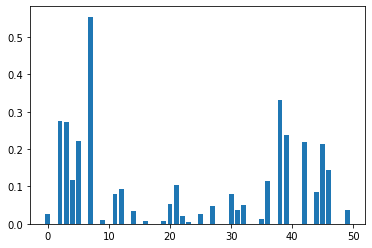

In [76]:
plt.bar(np.arange(0, 50), H3[:,0])

In [77]:
templateRatings.shape

(50, 10532)

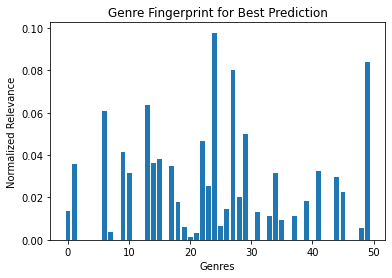

In [78]:
bestIndex = np.abs(testData['roundedRating'] - testData['rating']).argmin()
movieCol = np.array(testData['movieId'])
bestMovieIndex = movieCol[bestIndex] - 1
plt.bar(np.arange(0, 50), normalizedH3[:,bestMovieIndex]);
plt.title("Genre Fingerprint for Best Prediction");
plt.xlabel("Genres");
plt.ylabel("Normalized Relevance");

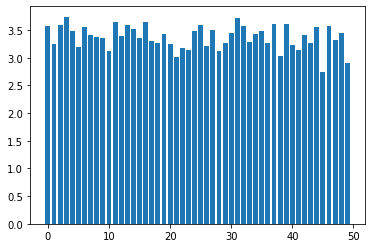

In [79]:
# bestIndex = np.abs(testData['roundedRating'] - testData['rating']).argmin()
userCol = np.array(testData['userId'])
userIndex = userCol[bestIndex] - 1
plt.bar(np.arange(0, 50), templateRatings[:,userIndex]);

There's less noise for the best prediction.

There are few high genres, and most are in the middle or low, which is good.

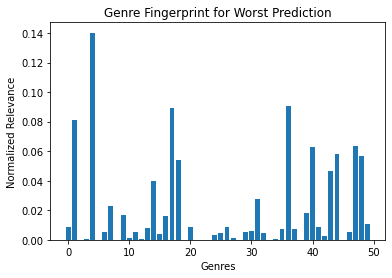

In [80]:
worstIndex = np.abs(testData['roundedRating'] - testData['rating']).argmax()
movieCol = np.array(testData['movieId'])
worstMovieIndex = movieCol[worstIndex] - 1
plt.bar(np.arange(0, 50), normalizedH3[:,worstMovieIndex]);
plt.title("Genre Fingerprint for Worst Prediction");
plt.xlabel("Genres");
plt.ylabel("Normalized Relevance");

<BarContainer object of 50 artists>

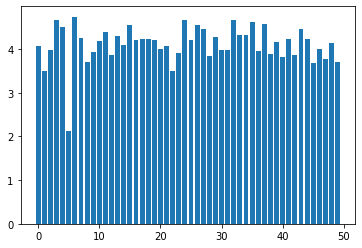

In [81]:
# userCol = np.array(testData['userId'])
userIndex = userCol[worstIndex] - 1
plt.bar(np.arange(0, 50), templateRatings[:,userIndex])

In the worst prediction, we see that the highest value is much lower than the previous random instance.

In [82]:
ratings.shape

(1024, 10532)

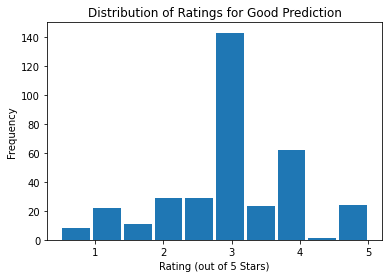

In [83]:
plt.hist(ratings[bestMovieIndex].flatten()[ratings[bestMovieIndex].flatten() != 0], bins=10, rwidth=0.9);
plt.title("Distribution of Ratings for Good Prediction");
plt.xlabel("Rating (out of 5 Stars)");
plt.ylabel("Frequency");

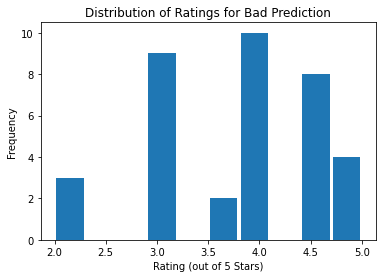

In [84]:
plt.hist(ratings[worstMovieIndex].flatten()[ratings[worstMovieIndex].flatten() != 0], bins=10, rwidth=0.9);
plt.title("Distribution of Ratings for Bad Prediction");
plt.xlabel("Rating (out of 5 Stars)");
plt.ylabel("Frequency");

In [85]:
# worstIndex = np.abs(testData['roundedRating'] - testData['rating']).argmax()
# movieCol = np.array(testData['movieId'])
# worstMovieIndex = movieCol[worstIndex] - 1
print("Worst Predicted Rating", np.array(testData['roundedRating'])[worstIndex])
print("Actual Rating: ", np.array(testData['rating'])[worstIndex])

Worst Predicted Rating 4.5
Actual Rating:  0.5


In [86]:
print("Best Predicted Rating", np.array(testData['roundedRating'])[bestIndex])
print("Actual Rating: ", np.array(testData['rating'])[bestIndex])

Best Predicted Rating 3.0
Actual Rating:  3.0
